# Test  AI Agent framework  AI A real estate agent 

In [1]:
import os , json, time , gc
import logging


from dotenv import load_dotenv
from IPython.display import display, HTML, Markdown
from tqdm import tqdm
from openai import OpenAI, AsyncOpenAI
from openai.types.chat import (ChatCompletion, 
                               ChatCompletionChunk,
                               ChatCompletionContentPartTextParam, 
                               ChatCompletionContentPartImageParam,
                               ChatCompletionStreamOptionsParam)
import asyncio
import aiohttp
import pandas as pd
import re
import torch


import nest_asyncio
nest_asyncio.apply() # for jupyter notebook

In [2]:
# import crewai AI agent framework # pip install crewai
from crewai import Crew, Agent, Task, Process 

from crewai_tools import ScrapeWebsiteTool, SerperDevTool
from crewai.tools import BaseTool, tool
from crewai import LLM
from pydantic import BaseModel, Field
from typing import List, Dict, Type
from crewai.project import CrewBase, agent, task, crew

import crewai
from pydantic import BaseModel, Field
from typing import List, Optional, Dict, Any

from crewai.memory import LongTermMemory, ShortTermMemory, EntityMemory
from crewai.memory.storage.rag_storage import RAGStorage
from crewai.memory.storage.ltm_sqlite_storage import LTMSQLiteStorage
from typing import List, Optional
from crewai_tools import ScrapeWebsiteTool, SerperDevTool


/home/johnsonhk88/.pyenv/versions/3.11.11/lib/python3.11/site-packages/pydantic/fields.py:1076: PydanticDeprecatedSince20: Using extra keyword arguments on `Field` is deprecated and will be removed. Use `json_schema_extra` instead. (Extra keys: 'required'). Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  warn(


In [3]:
# Crawl4AI is a web crawling and data extraction library designed for AI applications.

from crawl4ai import  AsyncWebCrawler, BrowserConfig, CrawlerRunConfig, CacheMode
import crawl4ai


from crawl4ai.chunking_strategy import (RegexChunking, 
                                        NlpSentenceChunking,
                                        OverlappingWindowChunking, 
                                        SlidingWindowChunking,
                                        FixedLengthWordChunking, 
                                        TopicSegmentationChunking) 

from crawl4ai.extraction_strategy import ( JsonCssExtractionStrategy, 
                                           JsonXPathExtractionStrategy,
                                          LLMExtractionStrategy, 
                                          CosineStrategy)
from crawl4ai.markdown_generation_strategy import DefaultMarkdownGenerator


from crawl4ai.content_filter_strategy import BM25ContentFilter, PruningContentFilter, LLMContentFilter

/home/johnsonhk88/.pyenv/versions/3.11.11/lib/python3.11/site-packages/pydantic/_internal/_config.py:323: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  warnings.warn(DEPRECATION_MESSAGE, DeprecationWarning)
/home/johnsonhk88/.pyenv/versions/3.11.11/lib/python3.11/site-packages/fake_http_header/constants.py:5: DeprecationWarning: read_text is deprecated. Use files() instead. Refer to https://importlib-resources.readthedocs.io/en/latest/using.html#migrating-from-legacy for migration advice.
  domain_to_search_engine_binary = read_text("fake_http_header.data", "top-level-domain-to-search-engines.json")
/home/johnsonhk88/.pyenv/versions/3.11.11/lib/python3.11/importlib/resources/_legacy.py:80: DeprecationWarning: open_text is deprecated. Use files() instead. Refer to https://importlib-resources.readthedocs.i

In [4]:
class CFG:

    USE_OPIK = False # for OPIK local LLM framework evaluation

    opikURL = "http://localhost:5173"

     # Set LLM host framework
    USE_OLLAMA = True # for OLLAMA local LLM framework
    USE_OPENROUTER = False # for OpenRouter LLM framework
    USE_OPENAI = False # for OpenAI LLM framework

    # search engine
    num_results = 3 # 5
    queryTime = "month" #"year"

    # Azure Opena Model
    llmModel1 = "gpt-4o-mini"
    llmModel2 = "gpt-4o"
    embedModel1 = "text-embedding-3-small" #1528 openai embedding model
    embedModel2 = "text-embedding-3-large"  # around 3000 dimension
    embedModel3 = "text-embedding-ada-002"
    embedModel4 = "azure-text-embedding-3-small"
    embedModel5 = "azure-text-embedding-3-large"

  
    
    openEmbedModel1 = "intfloat/multilingual-e5-small" # 512 dimension
    openEmbedModel2 = "sentence-transformers/distiluse-base-multilingual-cased-v1"
    openEmbedModel3 = "intfloat/multilingual-e5-large" # curent  # 1024 dimension 
    openEmbedModel4 = "Alibaba-NLP/gte-multilingual-base"
    openEmbedModel5 = "nomic-embed-text" # 768 dimension , support 8196 input 
    openEmbedModel6 = "mixedbread-ai/mxbai-embed-large-v1"  # 
    openEmbedModel7 =   "nomic-embed-text" 

    ollamallmModel1 = "ollama/deepseek-r1:8b"
    ollamallmModel2 = "ollama/deepseek-r1:7b"
    ollamallmModel3 = "ollama/qwen2.5" # Qwen 2.5 7B
    ollamallmModel4 = "ollama/llama3.2"
    ollamallmModel5 = "ollama/qwen3:8b" # Qwen 3 8B


    visionEmbedModel1 = "nomic-ai/nomic-embed-vision-v1.5"
    visionEmbedModel2 =  "openai/clip-vit-base-patch16" # openai vision embeding model 


    promptInjectModel1 = "protectai/deberta-v3-base-prompt-injection-v2"

    htmlMarkdownModel1 = "jinaai/reader-lm-0.5b"
    htmlMarkdownModel2 = "jinaai/reader-lm-1.5b"

    api_base1="http://localhost:11434" # Ollama API base URL

    # Load locally Open source Embedding model 
    modelPath = "./model" 
    fullModelPath = modelPath + "/" + openEmbedModel3

    #General chat completion
    stream = False
    top = 3
    max_tokens = 2048
    top_p = 1
    temperature = 0.5
    presence_penalty = 0
    frequency_penalty = 0


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
logger= logging.getLogger(__name__)

In [7]:
def set_log_level(logger ,level: str):
    if level == "DEBUG":
        logger.setLevel(logging.DEBUG)
    elif level == "INFO":
        logger.setLevel(logging.INFO)
    elif level == "WARNING":
        logger.setLevel(logging.WARNING)
    elif level == "ERROR":
        logger.setLevel(logging.ERROR)
    elif level == "CRITICAL":
        logger.setLevel(logging.CRITICAL)
    else:
        logger.setLevel(logging.DEBUG)

In [8]:
set_log_level(logger, "DEBUG")

### Inital Opik for AI agent debug tool

In [62]:
import opik
from opik.integrations.crewai import track_crewai
from litellm.integrations.opik.opik import OpikLogger
from opik import track

import litellm
from litellm import acompletion


if CFG.USE_OPIK:
    opik.configure(use_local=True, automatic_approvals=True , url=CFG.opikURL)

    opikProjectName = "AI-Agent-Real-Estate-Recommender"
    track_crewai(project_name=opikProjectName)
    opik_logger = OpikLogger()
    litellm.callbacks = [opik_logger]

In [10]:
from langchain_ollama import OllamaLLM, ChatOllama
from langchain_openai import ChatOpenAI

In [11]:
import ctypes
def clearMemory():
    for _ in range(5):
        torch.cuda.empty_cache()
        ctypes.CDLL("libc.so.6").malloc_trim(0)
        gc.collect()
        time.sleep(0.3)

In [12]:
query="Find me a 3 bedroom house in Hong Kong under $5 million"

In [13]:
# from crewai_tools import BraveSearchTool

# # Initialize the tool for internet searching capabilities
# tool = BraveSearchTool()

# SearxNG Web Search Engine

You can [check this link](https://docs.searxng.org/dev/search_api.html) for more informations about `Searx API` parameters.
#### Download SearxNG docker for local host setup web search Engine

In [14]:
import pprint
from langchain_community.utilities import SearxSearchWrapper

In [15]:
searchGeneralConfig = "!general"
searchImageConfig = "!images !bii !brimg !ddi !goi"
searchVideoConfig = "!videos !biv !brvid !ddv !gov"
searchNewConfig = "!news !gon !yhn"
searchMapConfig = "!map paris"
searchYouTubeConfig = "!yt"
searchSocialMedia = "!social_media !re !toot !mah !leco"

In [21]:
searxHost = "http://localhost:8080" #for langchain
searxHost2 = "http://localhost:8080/search" # for Searxng API directly
search = SearxSearchWrapper(searx_host=searxHost, k=5)

In [ ]:
## Find URL web page for the query use langchain Searxng search wrapper

def searchURL(q, k=3, qureyTime=CFG.queryTime, 
              engines=["duckduckgo", "qwant", "google", "brave"],
              categories = "general",
              querySuffix = None):
    results = search.results(q, 
                        num_results=k,
                        time_range = qureyTime,
                        engines= engines,
                        categories = categories,
                       query_suffix = querySuffix,
                       )
    
    return results

async def asyncSearchURL(q, k=3 , qureyTime=CFG.queryTime, 
                         engines=["duckduckgo", "qwant", "google", "brave"],
                         categories = "general",
                         querySuffix = None
                        ):
    startTime = time.time()
    results = await search.aresults(q, 
                        num_results=k,
                        time_range = qureyTime,
                        engines= engines,
                        categories = categories,
                        query_suffix = querySuffix,)
    print(f"Time take: {time.time() - startTime}")
    print(f"Query Categores : {categories}")
    return results
    

In [23]:
def extractURLs(ret):
    """ Extract URLs from the search results."""
    urls = []
    for val in ret:
        urls.append(val["link"])
    return urls

In [24]:
def joinContext(ret, separator= None):
    """
    Combine content
    """
    string=""
    for val in ret:
        # print(val)
        if separator :
            string += (val) + separator
        else :
            string += (val) + " "
    return string 

In [26]:
# %%time
queryTime = "month" #"year"#"month" #"year" #"day"
k = 5#5
currentQuery = "What is Hong Kong Weather Now?" #q2 #"Hong Kong Kwun Tong" #q3#tempQuery#q1
categories =  []#[""] #["science"]#["science", "image"]
query_suffix = None #searchMapConfig   # searchVideoConfig
urls = await asyncSearchURL(currentQuery, k=k, qureyTime=queryTime, categories=categories,  querySuffix= query_suffix)
print(currentQuery)
urls

Time take: 0.7432050704956055
Query Categores : []
What is Hong Kong Weather Now?


[{'snippet': '5 hours ago — Weather in Hong Kong, Hong Kong ... Passing clouds. Feels Like: 105 °F Forecast: 93 / 83 °F Wind: 20 mph ↑ from Southwest ...',
  'title': 'Weather for Hong Kong, Hong Kong',
  'link': 'https://www.timeanddate.com/weather/hong-kong/hong-kong',
  'engines': ['google'],
  'category': 'general'},
 {'snippet': '1 day ago - Stay informed and make the most of your day with our live weather updates from Hong Kong today. The temperature today in Hong Kong is expected to be typical for this time of year, with a forecast of 31 °C, closely aligning with the historical average for 5th of July.',
  'title': "Today's Weather in Hong Kong - Hourly Forecast and Conditions",
  'link': 'https://www.easeweather.com/asia/hong-kong/today',
  'engines': ['brave'],
  'category': 'general'},
 {'snippet': '2 days ago — At 3 p.m. at Hong Kong Observatory : Air Temperature : 34 degrees Celsius Relative Humidity : 57 per cent Weather Cartoon : No. 51 - SUNNY PERIODS During the ...',
  

In [27]:
df = pd.DataFrame(urls)
df

,snippet,title,link,engines,category
0,"5 hours ago — Weather in Hong Kong, Hong Kong ...","Weather for Hong Kong, Hong Kong",https://www.timeanddate.com/weather/hong-kong/...,[google],general
1,1 day ago - Stay informed and make the most of...,Today's Weather in Hong Kong - Hourly Forecast...,https://www.easeweather.com/asia/hong-kong/today,[brave],general
2,2 days ago — At 3 p.m. at Hong Kong Observator...,Current Weather,https://www.hko.gov.hk/textonly/forecast/engli...,[google],general
3,1 month ago - Residents have also been warned ...,Hong Kong to issue No 1 typhoon warning signal...,https://www.scmp.com/news/hong-kong/health-env...,[brave],general
4,15 hours ago — Provides weather forecast in Ho...,Temperature | Automatic Regional Weather Forec...,https://maps.weather.gov.hk/ocf/index_e.html,[google],general


In [29]:
urlsList = extractURLs(urls) 
print(urlsList)

['https://www.timeanddate.com/weather/hong-kong/hong-kong', 'https://www.easeweather.com/asia/hong-kong/today', 'https://www.hko.gov.hk/textonly/forecast/englishwx.htm', 'https://www.scmp.com/news/hong-kong/health-environment/article/3313582/hongkongers-swelter-coming-days-mercury-hit-34-degrees-celsius', 'https://maps.weather.gov.hk/ocf/index_e.html']


# Web scaping tool used Crawl4AI tool base on Playwrigth and Chrowmimum browswer


In [41]:
# Bros
# Test  playwright engine
from playwright.async_api import async_playwright

async def playwrightTestWeb():
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True) # launch browser
        page = await browser.new_page()
        await page.goto('https://www.google.com')
        print(f"Title of the page: {await page.title()}")
        await page.screenshot(path='example.png')# save screenshot
        await browser.close()

In [42]:
await playwrightTestWeb() # test the browser pylaywright engine

Title of the page: Google


In [43]:
browser_config= BrowserConfig(
    browser_type="chromium",
    headless=True,
    verbose=True,
    # for better performance in Docker or low memory menivroment 
    extra_args=["--disable-gpu", "--disable-dev-shm-usage", "--no-sandbox"],
    )

In [44]:
crawler_config1 = CrawlerRunConfig(
            # fetch_ssl_certificate=True,
            word_count_threshold=10, 
            excluded_tags=["form", "header"],
            exclude_external_links=True,
    
            markdown_generator=DefaultMarkdownGenerator(),
            # Content processing
            process_iframes=True,
            remove_overlay_elements=True,

            # Cache control 
            # cache_mode=CacheMode.ENABLED,
            cache_mode=CacheMode.BYPASS, # fetch each time
    
            page_timeout=120000, #60000, #30000, # for each image 
            wait_for_images=True,
            verbose=True,
)

In [45]:
async def getWebPageContent(url):
    """
    Fetch the single content of a web page using AsyncWebCrawler.
    """
    global browser_config
    async with AsyncWebCrawler() as crawler:
        # Configure the crawler
        result = await crawler.arun(
            url=url,
            browser_config=browser_config,
            run_config=CrawlerRunConfig(
                cache_mode=CacheMode.BYPASS,  # Disable caching
                # max_depth=1,  # Limit the depth of crawling
            )
        )
        return result
    

In [46]:
from crawl4ai.async_dispatcher import MemoryAdaptiveDispatcher
from crawl4ai import CrawlerMonitor, DisplayMode

async def getWebPageContentsConcurrent(urls, browser_config, 
                                       crawler_config):
    """
    Fetch the contents of multiple web pages concurrently.
    """
    dispatcher = MemoryAdaptiveDispatcher(
        memory_threshold_percent=95.0,
        check_interval=0.5,
        max_session_permit=5,
        # monitor=CrawlerMonitor(
        #      max_visible_rows=15,
        #     display_mode=DisplayMode.DETAILED
        #     )
        )
    async with AsyncWebCrawler() as crawler:
        # Create a dispatcher for concurrent requests
        try:
            startTime = time.time()
            successCnt = 0
            failureCnt = 0
            rets = [] # aggregate results
            results = await crawler.arun_many(
                urls=urls,
                browser_config=browser_config,
                run_config=crawler_config,
                dispatcher=dispatcher
            )
            for result in results:
                if isinstance(result, Exception):
                    print(f"Error fetching {result.url}: {result.error_message}")
                    failureCnt += 1
                    
                elif result.success:
                    print(f"Successfully fetched : {result.url}")
                    print(f"HTML length: {len(result.html)}")
                    print(f"Markdown length: {len(result.markdown)}")
                    print(f"Markdown snippet : {result.markdown[:200]}...")
                    rets.append(result)
                    successCnt += 1
                else:
                    print(f"Failed to fetch {result.url}: {result.error}")
                    failureCnt += 1
            
            print(f"Total URLs: {len(urls)}, Success: {successCnt}, Failures: {failureCnt}")
            print(f"Time Taken:  {time.time() - startTime}")


        except Exception as e:
            print(f"Error during crawling: {e}")
            results = None
        finally:
            await crawler.close()
        return rets 


# Single URL Web scraping test

In [47]:
rst = await (getWebPageContent(df.iloc[0].link)) # Get the content of the first URL

[INIT].... → Crawl4AI 0.6.3 

[FETCH]... ↓ https://www.timeanddate.com/weather/hong-kong/hong-kong                                              |
✓ | ⏱: 0.85s 

[SCRAPE].. ◆ https://www.timeanddate.com/weather/hong-kong/hong-kong                                              |
✓ | ⏱: 0.06s 

[COMPLETE] ● https://www.timeanddate.com/weather/hong-kong/hong-kong                                              |
✓ | ⏱: 0.91s 

In [48]:
(rst[0].model_dump())

{'url': 'https://www.timeanddate.com/weather/hong-kong/hong-kong',
 'html': '<!DOCTYPE html><html lang="en" style="--site-header-offset: 150px;"><head><meta http-equiv="Content-Type" content="text/html; charset=utf-8"><title>Weather for Hong Kong, Hong Kong</title><meta name="description" content="Current weather in Hong Kong and forecast for today, tomorrow, and next 14 days"><meta name="robots" content="max-image-preview:large"><meta property="og:image" content="https://www.timeanddate.com/scripts/cityog.php?title=Weather%20in&amp;tint=0x007b7a&amp;city=Hong%20Kong&amp;country=Hong%20Kong&amp;image=hong-kong1"><meta property="og:image:width" content="1366"><meta property="og:image:height" content="738"><meta property="og:type" content="website"><style>\n@font-face{font-family:iconfont;src:url("/common/fonts/iconfont.woff2?v8") format("woff2"),url("/common/fonts/iconfont.woff?v8") format("woff"),url("/common/fonts/iconfont.ttf?v8") format("truetype"),url("/common/fonts/iconfont.svg?v8

In [49]:
for item in rst:
    print(f"URL: {item.url}")
    # print(f"Title: {item.title}")
    print(f"Content: {item.html[:200]}...")  # Print first 200 characters of content
    # print(f"Images: {item.images}")
    print(f"Links: {item.links}")
    print(f"Markdown: {item.markdown[:200]}...")
    print(f"Metadata: {item.metadata}")  
    # print(f"Text: {item.text[:200]}...")  # Print first 200 characters of text
    print("-" * 80)  # Separator for readability

URL: https://www.timeanddate.com/weather/hong-kong/hong-kong
Content: <!DOCTYPE html><html lang="en" style="--site-header-offset: 150px;"><head><meta http-equiv="Content-Type" content="text/html; charset=utf-8"><title>Weather for Hong Kong, Hong Kong</title><meta name="...
Links: {'internal': [{'href': 'https://www.timeanddate.com/', 'text': '', 'title': 'Home page timeanddate.com', 'base_domain': 'timeanddate.com'}, {'href': 'https://www.timeanddate.com/news/', 'text': 'News', 'title': '', 'base_domain': 'timeanddate.com'}, {'href': 'https://www.timeanddate.com/news', 'text': 'News Home', 'title': '', 'base_domain': 'timeanddate.com'}, {'href': 'https://www.timeanddate.com/news/astronomy/', 'text': 'Astronomy News', 'title': '', 'base_domain': 'timeanddate.com'}, {'href': 'https://www.timeanddate.com/news/time/', 'text': 'Time Zone News', 'title': '', 'base_domain': 'timeanddate.com'}, {'href': 'https://www.timeanddate.com/news/calendar/', 'text': 'Calendar & Holiday News', 'title': '

In [50]:
def extractMarkdown(ret, types="all", extract="raw_markdown"):
    markdowns= []
    if types == "all":
        for item in ret:
            # data = item["_results"][0] # extract # new version
            logger.info(f"Extracting markdown from item: {type(item)}")
            data = item # old version
            print(f"Markdown: {data.markdown.raw_markdown[:200]}...")  
            markdowns.append(data.markdown.raw_markdown)

    elif types == "markdown":
        for item in ret:
            markdowns.append(item["markdown"])
    return markdowns

In [51]:
# urls = extractURLs(rst)

In [52]:
markdowns = extractMarkdown(rst, types="all", extract="raw_markdown")

2025-07-06 23:02:07,863 - 130943178214272 - 2048757435.py-2048757435:6 - INFO: Extracting markdown from item: <class 'crawl4ai.models.CrawlResult'>


Markdown: [](https://www.timeanddate.com/ "Home page timeanddate.com")
[![timeanddate.com](https://c.tadst.com/gfx/n/logo/logo-2021--horizontal-inverted-darkbg.svg)](https://www.timeanddate.com/ "Home page time...


In [53]:
Markdown(markdowns[0])

[](https://www.timeanddate.com/ "Home page timeanddate.com")
[![timeanddate.com](https://c.tadst.com/gfx/n/logo/logo-2021--horizontal-inverted-darkbg.svg)](https://www.timeanddate.com/ "Home page timeanddate.com")
Sign in
  * [News](https://www.timeanddate.com/news/)
    * [News Home](https://www.timeanddate.com/news)
    * [Astronomy News](https://www.timeanddate.com/news/astronomy/)
    * [Time Zone News](https://www.timeanddate.com/news/time/)
    * [Calendar & Holiday News](https://www.timeanddate.com/news/calendar/)
    * [Newsletter](https://www.timeanddate.com/newsletter/)
    * [Live events](https://www.timeanddate.com/live/)
  * [World Clock](https://www.timeanddate.com/worldclock/)
    * [Main World Clock](https://www.timeanddate.com/worldclock/)
    * [Extended World Clock](https://www.timeanddate.com/worldclock/full.html)
    * [Personal World Clock](https://www.timeanddate.com/worldclock/personal.html)
    * [Clock for Your Site](https://www.timeanddate.com/clocks/free.html)
    * [UTC Time](https://www.timeanddate.com/worldclock/timezone/utc)
  * [Time Zones](https://www.timeanddate.com/time/)
    * [Time Zones Home](https://www.timeanddate.com/time)
    * [Time Zone Converter](https://www.timeanddate.com/worldclock/converter.html)
    * [Meeting Planner](https://www.timeanddate.com/worldclock/meeting.html)
    * [Event Time Announcer](https://www.timeanddate.com/worldclock/fixedform.html)
    * [Time Zone Map](https://www.timeanddate.com/time/map/)
    * [Time Zone Abbreviations](https://www.timeanddate.com/time/zones/)
    * [Daylight Saving Time](https://www.timeanddate.com/time/dst/)
    * [Time Changes Worldwide](https://www.timeanddate.com/time/change/)
    * [Time Difference](https://www.timeanddate.com/time/difference/)
    * [Time Zone News](https://www.timeanddate.com/news/time/)
  * [Calendar](https://www.timeanddate.com/calendar/)
    * [Calendars Home](https://www.timeanddate.com/calendar/info.html)
    * [Calendar 2025](https://www.timeanddate.com/calendar/)
    * [Calendar 2026](https://www.timeanddate.com/calendar/?year=2026)
    * [Monthly Calendar](https://www.timeanddate.com/calendar/monthly.html)
    * [Printable Calendar (PDF)](https://www.timeanddate.com/calendar/create.html)
    * [Add Your Own Calendar Events](https://www.timeanddate.com/calendar/events/)
    * [Calendar Creator](https://www.timeanddate.com/calendar/basic.html)
    * [Holidays Worldwide](https://www.timeanddate.com/holidays/)
    * [On This Day in History](https://www.timeanddate.com/on-this-day/)
    * [Fun Holidays](https://www.timeanddate.com/holidays/fun/)
    * [Months of the Year](https://www.timeanddate.com/calendar/months/)
    * [Days of the Week](https://www.timeanddate.com/calendar/days/)
    * [About Leap Years](https://www.timeanddate.com/date/leapyear.html)
    * [Calendar & Holiday News](https://www.timeanddate.com/news/calendar/)
  * [Weather](https://www.timeanddate.com/weather/)
    * [Worldwide](https://www.timeanddate.com/weather/)
    * [Local Weather](https://www.timeanddate.com/scripts/go.php)
    * [2-Week Forecast](https://www.timeanddate.com/scripts/go.php?type=ext)
    * [Hour-by-Hour](https://www.timeanddate.com/scripts/go.php?type=hourly)
    * [Past Week](https://www.timeanddate.com/scripts/go.php?type=historic)
    * [Climate](https://www.timeanddate.com/scripts/go.php?type=climate)
  * [Sun, Moon & Space](https://www.timeanddate.com/astronomy/)
    * [Sun & Moon Home](https://www.timeanddate.com/astronomy)
    * [Sun Calculator](https://www.timeanddate.com/sun/)
    * [Moon Calculator](https://www.timeanddate.com/moon/)
    * [Moon Phases](https://www.timeanddate.com/moon/phases/)
    * [Night Sky](https://www.timeanddate.com/astronomy/night/)
    * [Meteor Showers](https://www.timeanddate.com/astronomy/meteor-shower/)
    * [Day and Night Map](https://www.timeanddate.com/worldclock/sunearth.html)
    * [Moon Light World Map](https://www.timeanddate.com/astronomy/moon/light.html)
    * [Eclipses](https://www.timeanddate.com/eclipse/)
    * [Live Streams](https://www.timeanddate.com/live/)
    * [Seasons](https://www.timeanddate.com/calendar/seasons.html)
    * [Astronomy News](https://www.timeanddate.com/news/astronomy/)
  * [Timers](https://www.timeanddate.com/counters/)
    * [Timers Home](https://www.timeanddate.com/counters)
    * [Stopwatch](https://www.timeanddate.com/stopwatch/)
    * [Timer](https://www.timeanddate.com/timer/)
    * [Countdown to Any Date](https://www.timeanddate.com/countdown/create)
    * [Eclipse Countdown](https://www.timeanddate.com/countdown/eclipse)
    * [Fall Countdown](https://www.timeanddate.com/countdown/fall)
    * [New Year Countdown](https://www.timeanddate.com/countdown/newyear)
    * [Countdown for Your Site](https://www.timeanddate.com/clocks/freecountdown.html)
  * [Calculators](https://www.timeanddate.com/date/)
    * [Calculators Home](https://www.timeanddate.com/date/)
    * [Date to Date Calculator (duration)](https://www.timeanddate.com/date/duration.html)
    * [Business Date to Date (exclude holidays)](https://www.timeanddate.com/date/workdays.html)
    * [Date Calculator (add / subtract)](https://www.timeanddate.com/date/dateadd.html)
    * [Business Date (exclude holidays)](https://www.timeanddate.com/date/weekdayadd.html)
    * [Weekday Calculator](https://www.timeanddate.com/date/weekday.html)
    * [Week Number Calculator](https://www.timeanddate.com/date/weeknumber.html)
    * [Roman Numeral Converter](https://www.timeanddate.com/date/roman-calculator.html)
    * [Alternative Age Calculator](https://www.timeanddate.com/date/birthday.html)
    * [Date Pattern Calculator](https://www.timeanddate.com/date/pattern.html)
    * [Distance Calculator](https://www.timeanddate.com/worldclock/distance.html)
  * [ My Account](https://www.timeanddate.com/custom/)
    * [My Account](https://www.timeanddate.com/custom)
    * [My Location](https://www.timeanddate.com/custom/location.html)
    * [My Units](https://www.timeanddate.com/custom/site.html)
    * [My Events](https://www.timeanddate.com/calendar/events/)
    * [My World Clock](https://www.timeanddate.com/worldclock/personal.html)
    * [My Privacy](https://www.timeanddate.com/custom/privacy.html)
    * [Paid Services](https://www.timeanddate.com/services/)
    * [Sign in](https://www.timeanddate.com/custom/login.html)
    * [Register](https://www.timeanddate.com/custom/create.html)


[Home](https://www.timeanddate.com/) [Weather](https://www.timeanddate.com/weather/) [Hong Kong](https://www.timeanddate.com/weather/hong-kong) Hong Kong
![Flag for Hong Kong](https://c.tadst.com/gfx/n/fl/48/hk.png)
# Weather in Hong Kong, Hong Kong
  * [Time/General](https://www.timeanddate.com/worldclock/hong-kong/hong-kong "General/main info about Hong Kong")
  * [Weather ](https://www.timeanddate.com/weather/hong-kong/hong-kong "Current weather and forecast for Hong Kong")
    * [Weather Today/Tomorrow ](https://www.timeanddate.com/weather/hong-kong/hong-kong "Shows a weather overview")
    * [Hour-by-Hour Forecast ](https://www.timeanddate.com/weather/hong-kong/hong-kong/hourly "Hour-by-hour weather for the coming week")
    * [14 Day Forecast ](https://www.timeanddate.com/weather/hong-kong/hong-kong/ext "Extended forecast for the next two weeks")
    * [Yesterday/Past Weather](https://www.timeanddate.com/weather/hong-kong/hong-kong/historic "Past weather for yesterday, the last 2 weeks, or any selected month available")
    * [Climate (Averages)](https://www.timeanddate.com/weather/hong-kong/hong-kong/climate "Historic weather and climate information")
  * [Time Zone ](https://www.timeanddate.com/time/zone/hong-kong/hong-kong "Past and future time change dates for Hong Kong")
  * [DST Changes](https://www.timeanddate.com/time/change/hong-kong/hong-kong "Daylight saving time changeover dates and times for Hong Kong")
  * [Sun & Moon ](https://www.timeanddate.com/astronomy/hong-kong/hong-kong "Calculate rising and setting times for the Sun and Moon in Hong Kong")
    * [Sun & Moon Today ](https://www.timeanddate.com/astronomy/hong-kong/hong-kong)
    * [Sunrise & Sunset ](https://www.timeanddate.com/sun/hong-kong/hong-kong)
    * [Moonrise & Moonset ](https://www.timeanddate.com/moon/hong-kong/hong-kong)
    * [Moon Phases ](https://www.timeanddate.com/moon/phases/hong-kong/hong-kong)
    * [Eclipses ](https://www.timeanddate.com/eclipse/in/hong-kong/hong-kong)
    * [Night Sky ](https://www.timeanddate.com/astronomy/night/hong-kong/hong-kong)


[Weather Today](https://www.timeanddate.com/weather/hong-kong/hong-kong "Shows a weather overview")[Weather Hourly](https://www.timeanddate.com/weather/hong-kong/hong-kong/hourly "Hour-by-hour weather for the coming week")[14 Day Forecast](https://www.timeanddate.com/weather/hong-kong/hong-kong/ext "Extended forecast for the next two weeks")[Yesterday/Past Weather](https://www.timeanddate.com/weather/hong-kong/hong-kong/historic "Past weather for yesterday, the last 2 weeks, or any selected month available")[Climate (Averages)](https://www.timeanddate.com/weather/hong-kong/hong-kong/climate "Historic weather and climate information")
Now
![](https://c.tadst.com/gfx/w/svg/wt-14.svg)
30 °C
Passing clouds.
Feels Like: 39 °CForecast: 34 / 29 °CWind: 22 km/h ↑ from Southwest
Location: | Hong Kong International Airport  
---|---  
Current Time: | 6 Jul 2025, 23:01:46  
Latest Report: | 6 Jul 2025, 22:30  
Visibility: | N/A  
Pressure: | 1003 mbar  
Humidity: | 84%  
Dew Point: | 27 °C  
[![Location of Hong Kong](https://c.tadst.com/gfx/citymap/hk-10.png?12)![Location](https://c.tadst.com/gfx/n/icon/icon-map-pin.png)](https://www.timeanddate.com/time/map/#!cities=102)
## Upcoming 5 hours
[](https://www.timeanddate.com/custom/site.html "Change Units")Now| 00:00| 01:00| 02:00| 03:00| 04:00  
---|---|---|---|---|---  
![](https://c.tadst.com/gfx/w/svg/wt-14.svg)| ![](https://c.tadst.com/gfx/w/svg/wt-34.svg)| ![](https://c.tadst.com/gfx/w/svg/wt-34.svg)| ![](https://c.tadst.com/gfx/w/svg/wt-34.svg)| ![](https://c.tadst.com/gfx/w/svg/wt-34.svg)| ![](https://c.tadst.com/gfx/w/svg/wt-34.svg)  
30 °C| 29 °C| 29 °C| 29 °C| 29 °C| 29 °C  
[See more hour-by-hour weather](https://www.timeanddate.com/weather/hong-kong/hong-kong/hourly)
## Forecast for the next 48 hours
Scroll right to see more | Monday| Tuesday  
---|---|---  
| Night| Morning| Afternoon| Evening| Night| Morning| Afternoon  
Forecast| ![](https://c.tadst.com/gfx/w/svg/wt-34.svg)| ![](https://c.tadst.com/gfx/w/svg/wt-33.svg)| ![](https://c.tadst.com/gfx/w/svg/wt-2.svg)| ![](https://c.tadst.com/gfx/w/svg/wt-17.svg)| ![](https://c.tadst.com/gfx/w/svg/wt-17.svg)| ![](https://c.tadst.com/gfx/w/svg/wt-33.svg)| ![](https://c.tadst.com/gfx/w/svg/wt-33.svg)  
Temperature| 29 °C| 32 °C| 34 °C| 30 °C| 29 °C| 31 °C| 33 °C  
| Passing showers. Overcast.| Passing showers. Broken clouds.| Scatt­erred clouds.| Cloudy.| Mostly cloudy.| Passing showers. Cloudy.| Passing showers. Overcast.  
Feels Like| 35 °C| 39 °C| 42 °C| 36 °C| 35 °C| 39 °C| 40 °C  
Wind Speed| 20 km/h| 18 km/h| 23 km/h| 17 km/h| 12 km/h| 16 km/h| 17 km/h  
Wind Direction| WSW↑| WSW↑| SW↑| SSW↑| SW↑| SW↑| SSW↑  
Humidity| 81%| 68%| 62%| 78%| 82%| 71%| 64%  
Dew Point| 26 °C| 25 °C| 25 °C| 25 °C| 26 °C| 25 °C| 25 °C  
Visibility| 9 km| 10 km| 12 km| 11 km| 10 km| 10 km| 11 km  
Probability of Precipitation| 25%| 22%| 5%| 0%| 5%| 25%| 24%  
Amount of Rain| 0.6 mm| 0.4 mm| 0.0 mm| 0.0 mm| 0.0 mm| 0.5 mm| 0.5 mm  
Amount of Snow| 0.0 mm| 0.0 mm| 0.0 mm| 0.0 mm| 0.0 mm| 0.0 mm| 0.0 mm  
* Updated Sunday, 6 July 2025 21:02:21 Hong Kong time - Weather by CustomWeather, © 2025  
[14 day forecast, day-by-day](https://www.timeanddate.com/weather/hong-kong/hong-kong/ext)[Hour-by-hour forecast for next week](https://www.timeanddate.com/weather/hong-kong/hong-kong/hourly)
![](https://c.tadst.com/gfx/w/svg/wt-2.svg)
### Yesterday's weather
Passing clouds. 34 / 28 °CHumidity: 71%. Wind: 11 km/h ↑ from East
[More weather last week](https://www.timeanddate.com/weather/hong-kong/hong-kong/historic)
### Currently at nearby stations
![](https://c.tadst.com/gfx/w/svg/wt-14.svg)31 °C
### National Airport: (3 km)
Passing clouds. (3 hours ago)
![](https://c.tadst.com/gfx/w/svg/wt-36.svg)30 °C
### Sha Tin: (10 km)
Warm. (2 hours ago)
![](https://c.tadst.com/gfx/w/svg/wt-36.svg)31 °C
### Ta Kwu Ling: (25 km)
Warm. (3 hours ago)
[More weather in Hong Kong](https://www.timeanddate.com/weather/hong-kong)
## Forecast for the next 2 weeks
Scroll right to see moreMon| Tue| Wed| Thu| Fri| Sat| Sun  
---|---|---|---|---|---|---  
7![](https://c.tadst.com/gfx/w/svg/wt-33.svg)34 / 29 °C| 8![](https://c.tadst.com/gfx/w/svg/wt-33.svg)33 / 29 °C| 9![](https://c.tadst.com/gfx/w/svg/wt-21.svg)34 / 27 °C| 10![](https://c.tadst.com/gfx/w/svg/wt-22.svg)34 / 28 °C| 11![](https://c.tadst.com/gfx/w/svg/wt-21.svg)31 / 28 °C| 12![](https://c.tadst.com/gfx/w/svg/wt-22.svg)32 / 27 °C| 13![](https://c.tadst.com/gfx/w/svg/wt-33.svg)34 / 27 °C  
14![](https://c.tadst.com/gfx/w/svg/wt-22.svg)30 / 28 °C| 15![](https://c.tadst.com/gfx/w/svg/wt-21.svg)29 / 27 °C| 16![](https://c.tadst.com/gfx/w/svg/wt-33.svg)29 / 28 °C| 17![](https://c.tadst.com/gfx/w/svg/wt-33.svg)29 / 28 °C| 18![](https://c.tadst.com/gfx/w/svg/wt-22.svg)29 / 28 °C| 19![](https://c.tadst.com/gfx/w/svg/wt-22.svg)29 / 28 °C| 20![](https://c.tadst.com/gfx/w/svg/wt-2.svg)29 / 28 °C  
21![](https://c.tadst.com/gfx/w/svg/wt-33.svg)30 / 28 °C| 22| 23| 24| 25| 26| 27  
[Detailed forecast for 14 days](https://www.timeanddate.com/weather/hong-kong/hong-kong/ext)
[ Need some help?](https://www.timeanddate.com/weather/city-help.html)
Advertising
How was your experience? Thank you for your feedback! [](https://www.timeanddate.com/weather/hong-kong/hong-kong "Vote Good") [ ](https://www.timeanddate.com/weather/hong-kong/hong-kong "Vote Bad") [Contact Us ](https://www.timeanddate.com/information/feedback.html?url=/weather/hong-kong/hong-kong)
[ ![Illustration of a pink shield with a white heart.](https://c.tadst.com/gfx/n/i/service__supporter.svg) ](https://www.timeanddate.com/services/supporter.html)
####  [ Love Our Site? Become a Supporter ](https://www.timeanddate.com/services/supporter.html)
  * Browse our site **advert free.**
  * Sun & Moon times **precise to the second.**
  * **Exclusive calendar templates** for PDF Calendar.

[![The timeanddate logo](https://c.tadst.com/gfx/n/logo/logo-2021--horizontal-color-whitebg.svg)](https://www.timeanddate.com/)
[© Time and Date AS 1995–2025](https://www.timeanddate.com/information/copyright.html)
#### Company
  * [About us](https://www.timeanddate.com/company/)
  * [Careers/Jobs](https://www.timeanddate.com/company/jobs)
  * [Contact Us](https://www.timeanddate.com/information/feedback.html?url=/weather/hong-kong/hong-kong)
  * [Contact Details](https://www.timeanddate.com/information/contact.html)
  * [Sitemap](https://www.timeanddate.com/sitemap.html)
  * [Newsletter](https://www.timeanddate.com/newsletter/)


#### Legal
  * [Link policy](https://www.timeanddate.com/information/copyright.html)
  * [Advertising](https://www.timeanddate.com/information/advertising.html)
  * [Disclaimer](https://www.timeanddate.com/information/disclaimer.html)
  * [Terms & Conditions](https://www.timeanddate.com/information/terms-conditions.html)
  * [Privacy Policy](https://www.timeanddate.com/information/privacy.html)
  * [Privacy Settings](https://www.timeanddate.com/custom/privacy.html)


#### Services
  * [World Clock](https://www.timeanddate.com/worldclock/)
  * [Time Zones](https://www.timeanddate.com/time/)
  * [Calendar](https://www.timeanddate.com/calendar/)
  * [Weather](https://www.timeanddate.com/weather/)
  * [Sun & Moon](https://www.timeanddate.com/astronomy/)
  * [Timers](https://www.timeanddate.com/counters/)
  * [Calculators](https://www.timeanddate.com/date/)
  * [API](https://www.timeanddate.com/services/api/)
  * [Apps](https://www.timeanddate.com/extra/)
  * [RSS Feeds](https://www.timeanddate.com/information/rss-feeds.html)


#### Sites
  * [timeanddate.no](https://www.timeanddate.no)
  * [timeanddate.de](https://www.timeanddate.de)


#### Follow Us
[](https://www.facebook.com/timeanddate/) [](https://twitter.com/timeanddate) [](https://www.linkedin.com/company/time-and-date-as/about/) [](https://www.instagram.com/timeanddatecom/) [](https://www.youtube.com/c/timeanddate)
© Time and Date AS 1995–2025. [Privacy & Terms](https://www.timeanddate.com/information/copyright.html)
![](https://ad-delivery.net/px.gif?ch=2)![](https://ad.doubleclick.net/favicon.ico?ad=300x250&ad_box_=1&adnet=1&showad=1&size=250x250)![](https://ad-delivery.net/px.gif?ch=1&e=0.6686482549348621)


In [438]:
## Test concurrent fetching of multiple web pages

In [54]:
res2 = asyncio.run(getWebPageContentsConcurrent(df.link.tolist(), 
                                                browser_config=browser_config, 
                                                crawler_config=crawler_config1))

[INIT].... → Crawl4AI 0.6.3 

[FETCH]... ↓ https://www.hko.gov.hk/textonly/forecast/englishwx.htm                                               |
✓ | ⏱: 0.61s 

[SCRAPE].. ◆ https://www.hko.gov.hk/textonly/forecast/englishwx.htm                                               |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://www.hko.gov.hk/textonly/forecast/englishwx.htm                                               |
✓ | ⏱: 0.61s 

[FETCH]... ↓ https://maps.weather.gov.hk/ocf/index_e.html                                                         |
✓ | ⏱: 1.08s 

[SCRAPE].. ◆ https://maps.weather.gov.hk/ocf/index_e.html                                                         |
✓ | ⏱: 0.01s 

[COMPLETE] ● https://maps.weather.gov.hk/ocf/index_e.html                                                         |
✓ | ⏱: 1.09s 

[FETCH]... ↓ https://www.timeanddate.com/weather/hong-kong/hong-kong                                              |
✓ | ⏱: 0.85s 

[SCRAPE].. ◆ https://www.timeanddate.com/weather/hong-kong/hong-kong                                              |
✓ | ⏱: 0.05s 

[COMPLETE] ● https://www.timeanddate.com/weather/hong-kong/hong-kong                                              |
✓ | ⏱: 0.90s 

[FETCH]... ↓ https://www.easeweather.com/asia/hong-kong/today                                                     |
✓ | ⏱: 1.92s 

[SCRAPE].. ◆ https://www.easeweather.com/asia/hong-kong/today                                                     |
✓ | ⏱: 0.07s 

[COMPLETE] ● https://www.easeweather.com/asia/hong-kong/today                                                     |
✓ | ⏱: 1.99s 

[FETCH]... ↓ https://www.scmp.com/news/hong-kong/health-envir...elter-coming-days-mercury-hit-34-degrees-celsius  |
✓ | ⏱: 1.83s 

[SCRAPE].. ◆ https://www.scmp.com/news/hong-kong/health-envir...elter-coming-days-mercury-hit-34-degrees-celsius  |
✓ | ⏱: 0.03s 

[COMPLETE] ● https://www.scmp.com/news/hong-kong/health-envir...elter-coming-days-mercury-hit-34-degrees-celsius  |
✓ | ⏱: 1.87s 

Successfully fetched : https://www.hko.gov.hk/textonly/forecast/englishwx.htm
HTML length: 2898
Markdown length: 1899
Markdown snippet : ![Hong Kong Observatory Logo](https://www.hko.gov.hk/images_e/logo_dblue.gif)
# Current Weather
_Bulletin updated at 22:02 HKT 06/Jul/2025_
```
At 10 p.m. at Hong Kong Observatory :
Air Temperature : ...
Successfully fetched : https://maps.weather.gov.hk/ocf/index_e.html
HTML length: 257372
Markdown length: 780
Markdown snippet : ×
Oh no! We are sorry, but your browser does not seem to support WebGL. The webpage is best viewed by browsers that comply with HTML5 standard and that support JavaScript and WebGL (e.g. Chrome, Firef...
Successfully fetched : https://www.timeanddate.com/weather/hong-kong/hong-kong
HTML length: 53102
Markdown length: 16696
Markdown snippet : [](https://www.timeanddate.com/ "Home page timeanddate.com")
[![timeanddate.com](https://c.tadst.com/gfx/n/logo/logo-2021--horizontal-inverted-darkbg.svg)](https://www.timeanddate.com/ "H

[CrawlResultContainer([CrawlResult(url='https://www.hko.gov.hk/textonly/forecast/englishwx.htm', html='<html lang="en"><head>\n\t\t<title>Current Weather</title>\n\t\t<meta name="Keywords" content="Current Weather">\n\t\t<meta name="Description" content="Current Weather">\n\t\t<meta name="Comments" content="WCAG2.0_Verified">\n\t\t<meta http-equiv="Content-Type" content="text/html; CHARSET=UTF-8">\n\t\t<script type="text/javascript" src="/js/jquery/jquery-1.6.4.min.js"></script>\n\t\t<script type="text/javascript" src="/js/clf_textonly.js"></script>\n\t</head>\n\t<body>\n\t<link rel="SHORTCUT ICON" href="/Logo.ico">\n<p align="center"><img src="../../images_e/logo_dblue.gif" alt="Hong Kong Observatory Logo" width="333" height="65">\n</p><h1 align="center">Current Weather</h1><p>\n<i>Bulletin updated at 22:02 HKT 06/Jul/2025</i>\n</p>\n<!--Current Weather-->\n<pre>At 10 p.m. at Hong Kong Observatory :\nAir Temperature : 30 degrees Celsius\nRelative Humidity : 77 per cent\nWeather Cartoo
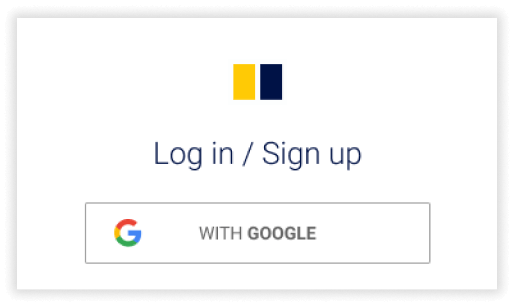

In [55]:
res2

In [56]:
markdowns2 = extractMarkdown(res2, types="all", extract="raw_markdown")
print(f"Number of Markdown Page : {len(markdowns2)}")

2025-07-06 23:02:30,061 - 130943178214272 - 2048757435.py-2048757435:6 - INFO: Extracting markdown from item: <class 'crawl4ai.models.CrawlResultContainer'>
2025-07-06 23:02:30,062 - 130943178214272 - 2048757435.py-2048757435:6 - INFO: Extracting markdown from item: <class 'crawl4ai.models.CrawlResultContainer'>
2025-07-06 23:02:30,062 - 130943178214272 - 2048757435.py-2048757435:6 - INFO: Extracting markdown from item: <class 'crawl4ai.models.CrawlResultContainer'>
2025-07-06 23:02:30,062 - 130943178214272 - 2048757435.py-2048757435:6 - INFO: Extracting markdown from item: <class 'crawl4ai.models.CrawlResultContainer'>
2025-07-06 23:02:30,063 - 130943178214272 - 2048757435.py-2048757435:6 - INFO: Extracting markdown from item: <class 'crawl4ai.models.CrawlResultContainer'>


Markdown: ![Hong Kong Observatory Logo](https://www.hko.gov.hk/images_e/logo_dblue.gif)
# Current Weather
_Bulletin updated at 22:02 HKT 06/Jul/2025_
```
At 10 p.m. at Hong Kong Observatory :
Air Temperature : ...
Markdown: ×
Oh no! We are sorry, but your browser does not seem to support WebGL. The webpage is best viewed by browsers that comply with HTML5 standard and that support JavaScript and WebGL (e.g. Chrome, Firef...
Markdown: [](https://www.timeanddate.com/ "Home page timeanddate.com")
[![timeanddate.com](https://c.tadst.com/gfx/n/logo/logo-2021--horizontal-inverted-darkbg.svg)](https://www.timeanddate.com/ "Home page time...
Markdown: [![easeweather.com](https://www.easeweather.com/images/easeweather.com.svg)](https://www.easeweather.com)
Units
°C
°F
Hong Kong
[Forecast](https://www.easeweather.com/asia/hong-kong) [Today](https://w...
Markdown: Edition:
International
[](https://www.scmp.com/mynews)
[SUBSCRIBE](https://subscribe.scmp.com/)
Get unlimited access to the SCMP
HIGHL

In [57]:
Markdown(markdowns2[1][:2000])

×
Oh no! We are sorry, but your browser does not seem to support WebGL. The webpage is best viewed by browsers that comply with HTML5 standard and that support JavaScript and WebGL (e.g. Chrome, Firefox, Edge, Safari).To update your browsers, please visit one of the websites listed below:
[Edge Product Home Page](https://www.microsoft.com/en-us/windows/microsoft-edge "Edge Product Home Page") [Mozilla Firefox Product Home Page](http://www.mozilla.org/en-US/firefox/fx/ "Mozilla Firefox Product Home Page") [Safari Product Home Page](http://www.apple.com/safari/ "Safari Product Home Page") [Google Chrome Product Home Page](https://www.google.com/intl/en/chrome/browser/ "Google Chrome Product Home Page")
Also, You could:
Go To Text-only versionSwitch to traditional version


## Start Crewai AI Agent Framework

In [58]:
# set LLM model for AI agent
if CFG.USE_OLLAMA:
    llm =LLM(
        model=CFG.ollamallmModel5,
        temperature=0.7,
        max_tokens=CFG.max_tokens,       
    )



### Define AI agent tool

In [59]:
def agent_step_Callback(stepout):
    """
    Callback function for agent step.
    """
    print(f"Agent Step callback: type {type(stepout)} , step: {stepout} ")


def task_callback(taskout):
    """
    Callback function for task.
    """
    logger.info(f"""Task callback:\n
                     ask Agent Name : {taskout.agent}\n
                    task description: {taskout.description}\n
                    task summary: {taskout.summary}\n
                    output: {taskout.raw} """)

In [ ]:
if CFG.USE_OPIK:
    # Set
    @track(name="Chat Completion", project_name=opikProjectName)
    async def Complation(msg):
        """Asynchronous chat completion function.
        """
        # global stream
        stream = CFG.stream
        if CFG.USE_OLLAMA:
            model = CFG.ollamallmModel5
            apikey = None
            baseURL = CFG.api_base1
            

        if stream == True:
            streamOption = ChatCompletionStreamOptionsParam(include_usage=True) 
        else:
            streamOption = None

        res = await acompletion(   
            model=model,
            messages=msg,

            stream=stream,
            stream_options=streamOption,

            max_tokens=CFG.max_tokens,
            top_p=CFG.top_p,
            temperature=CFG.temperature,
            presence_penalty=CFG.presence_penalty,
            frequency_penalty=CFG.frequency_penalty,
            api_key=apikey,
            base_url=baseURL

        )
        return res
else:
     @track(name="Chat Completion", project_name=opikProjectName)
    async def Complation(msg):
        """Asynchronous chat completion function.
        """
        # global stream
        stream = CFG.stream
        if CFG.USE_OLLAMA:
            model = CFG.ollamallmModel5
            apikey = None
            baseURL = CFG.api_base1
            

        if stream == True:
            streamOption = ChatCompletionStreamOptionsParam(include_usage=True) 
        else:
            streamOption = None

        res = await acompletion(   
            model=model,
            messages=msg,

            stream=stream,
            stream_options=streamOption,

            max_tokens=CFG.max_tokens,
            top_p=CFG.top_p,
            temperature=CFG.temperature,
            presence_penalty=CFG.presence_penalty,
            frequency_penalty=CFG.frequency_penalty,
            api_key=apikey,
            base_url=baseURL

        )
        return res



        

NameError: name 'opikProjectName' is not defined

In [61]:
# Custom web search tool for AI Agent


In [447]:
# Custom web scraping tool for AI Agent

In [448]:
# Initialize tools
scrape_tool = ScrapeWebsiteTool()
search_tool = SerperDevTool()

In [449]:
# Define Agents
market_researcher = Agent(
    role="Market Researcher",
    goal="Gather and analyze real estate market trends from web and news sources",
    backstory="You are an expert in real estate market analysis with a keen eye for identifying trends, price movements, and emerging opportunities. You use web search and scraping to collect relevant data.",
    # tools=[search_tool, scrape_tool],
    llm=llm,
    verbose=True
)

social_media_analyst = Agent(
    role="Social Media Analyst",
    goal="Analyze social media platforms (LinkedIn, Facebook, Instagram) for real estate discussions and user preferences",
    backstory="You specialize in extracting insights from social media platforms, identifying user sentiments, and detecting real estate preferences from posts and comments.",
    # tools=[search_tool],
    llm=llm,
    verbose=True
)

data_analyst = Agent(
    role="Data Analyst",
    goal="Process and clean data from market and social media sources to identify key patterns",
    backstory="You are a data scientist skilled in cleaning, structuring, and analyzing complex datasets to uncover actionable insights for real estate recommendations.",
    llm=llm,
    verbose=True
)

recommendation_engineer = Agent(
    role="Recommendation Engineer",
    goal="Generate personalized real estate recommendations based on user preferences and market data",
    backstory="You are an AI engineer specializing in recommendation systems, capable of synthesizing market and user data to provide tailored property suggestions.",
    llm=llm,
    verbose=True
)


In [450]:
# Define Tasks
market_research_task = Task(
    description="""Search the web and scrape relevant websites for recent real estate market trends, including price changes, demand patterns, and emerging neighborhoods. Focus on a specific city (e.g., New York). Summarize findings in a concise report.""",
    expected_output="A JSON object containing market trends, including average prices, demand indicators, and notable neighborhoods.",
    agent=market_researcher
)

social_media_task = Task(
    description="""Search LinkedIn and Facebook for posts and discussions related to real estate in the target city (e.g., New York). Identify user preferences, such as desired property types (e.g., apartments, houses), budget ranges, and preferred locations. Summarize insights in a structured format.""",
    expected_output="A JSON object summarizing user preferences from social media, including property types, budget ranges, and preferred locations.",
    agent=social_media_analyst
)

data_analysis_task = Task(
    description="""Combine data from market research and social media analysis. Clean and structure the data, identifying key patterns such as high-demand property types and budget-aligned neighborhoods. Output a structured dataset ready for recommendation.""",
    expected_output="A JSON object with cleaned and analyzed data, highlighting key patterns and correlations.",
    agent=data_analyst
)

recommendation_task = Task(
    description="""Using the analyzed data, generate personalized real estate recommendations for users seeking properties in the target city. Recommendations should include property type, location, and estimated price range, tailored to user preferences and market trends.""",
    expected_output="A JSON object containing a list of recommended properties with details (type, location, price range).",
    agent=recommendation_engineer
)

In [451]:
real_estate_crew = Crew(
    agents=[market_researcher, social_media_analyst, data_analyst, recommendation_engineer],
    tasks=[market_research_task, social_media_task, data_analysis_task, recommendation_task],
    process=Process.sequential,
    verbose=True
)